<a href="https://colab.research.google.com/github/cqschlortt/Solving-4x4-Sudoku-with-Grover-s-Algorithm/blob/main/Grover_Sudoku.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Solve a 4x4 sudoku puzzle using Grover's Algorithm

The following code solves a 4x4 sudoku puzzle.  There are two different methods utilized, named oracle_1 and oracle_2.  

oracle_1 solves the sudoku puzzle by building a list of constraints which compare two cells at a time and checks that no number is repeated in each row, column, and block.  However, due to the fact that the size of the constraint list grows quickly as the number of empty cells increasses, it only runs in qiskit for very few empty cells (ie less than 4 empty cells) as more conditions requires more memory than qiskit is capable of.

oracle_2 actually solves a latin squares problem (ie only checks rows and columns), but will run for a higher number of empty cells (less than 8) since it requires fewer ancilla registers for the conditions.

## Preliminaries

In this section we will create several global variables to be used throughout the program for both oracles.

###A

A is the given puzzle with a certain number of blank space represented by '*' in an n^2xn^2 array

###location_b

location_b is a list containing the row and column number of each blank cell

###sp

sp is the number of blank cells in the given puzzle

###iterations

iterations is the number of times to run the algorithm to get the optimal solution

### Install needed packages and import

In [63]:
%pip install qiskit numpy
%pip install pylatexenc
%pip install qiskit_aer

In [64]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister, ClassicalRegister
from qiskit.quantum_info import Statevector, Operator

import matplotlib.pyplot as plt
from itertools import permutations

from qiskit_aer import AerSimulator, Aer
from qiskit.compiler import transpile

import numpy as np

### Create test puzzle for the program

In [65]:
#Example sodoku puzzle, n^2xn^2:

#This works for oracle_2, not oracle_1
n = 2
A = np.array([2, 0, 3, 1, 1, '*', '*', 0, 0, '*', '*', '*', 3, '*', '*', 2])
A = A.reshape(4, 4)

A


#This works for both oracle_1 and oracle_2
n = 2
A = np.array([2, 0, 3, 1, 1, 3, 2, '*', 0, 2, 1, 3, '*', 1, 0, 2])
A = A.reshape(4, 4)

A

array([['2', '0', '3', '1'],
       ['1', '3', '2', '*'],
       ['0', '2', '1', '3'],
       ['*', '1', '0', '2']], dtype='<U21')

### Extract data from the puzzle to be used in both processes

In [66]:
#Data for both oracles

#Record where the blanks are
location_b = []
for i in range(len(A)):
  for j in range(len(A)):
    if A[i][j] == '*':
      location_b.append([i, j])

#Count the number of blank spaces
sp = len(location_b)
print(f"Number of unknowns {sp}")

Number of unknowns 2


### Calculate the optimal number of iterations and success probability

In [67]:
#Calculating the number of iterations for Grover's algorithm

#Arguments:
#sp : found above, it is the number of empty cells.
#number_of_values : is the number of possible values for each cell, in 4X4 sudoku this number is 4 in 9x9 is 9.

number_of_values=4

def grover_iterations(sp,number_of_values):
  # Search space size

  N = number_of_values ** sp

  #Optimal number of iterations:
  optimal= np.pi * np.sqrt(N) / 4
  iterations = int(np.floor(optimal))

  #Success Probability

  theta = (2* iterations +1)* np.arcsin(1/np.sqrt(N))
  success_prob=np.sin(theta)**2

  print(f"Number of Iterations:{iterations}")
  return iterations

  #Example
iterations = grover_iterations(sp,number_of_values)

Number of Iterations:3


## Diffuser

Below the diffuser is built based on the number of qubits it needs to run on, as for both oracles, the diffuser should only be appended to the part of the circuit which holds the data for the empty cells (this will be blanks for both circuits).

Purpose: The diffuser is applied after the oracle, and takes the state marked by the oracle and increases its probability by reflecting values over the mean (since the marked state will be 'negative', the diffuser's reflection makes its probability larger after application)

Parameters: num_q is the number of qubits on which the diffuser should be applied (for both oracles, this should be 2*sp)

Output: A gate which can be appended to a circuit and which applies the operations of the diffuser

Method: First, a circuit of size num_q is created (this is the diffuser circuit and will be what we apply operations to).  Next, we know that the diffuser on num_q qubits is represented by $D = 2|s> <s| - I$, where $|s>$ is the equally distributed state of numq qubits.

Since $H^{\otimes {numq}}|s> = |0>$, then $H^{\otimes {numq}}DH^{\otimes {numq}} = H^{\otimes {numq}} (2|s> <s| - I) H^{\otimes {numq}} = 2|0><0| - I = X^{\otimes {numq}}C_{numq-1}ZX^{\otimes {numq}}$

Since $H^{\otimes {numq}}$ is its own inverse, $D = H^{\otimes {numq}}X^{\otimes {numq}}C_{numq-1}ZX^{\otimes {numq}}H^{\otimes {numq}}$

Thus we can build the diffuser on num_q qubits by applying a Hadamard gate to all of the qubits in the diffuser circuit, applying an x gate to all of the qubits in the circuit, then implementing a multicontrolled z gate by applying a Hadamard gate to all but one of the diffuser circuit qubits, applying a multicontrolled x gate for which the first num_q -1 qubits are the control and the last qubit is the target, then appling a Haramard gate to the first num_q -1 qubits again (since Z = HXH).  Then the x gate and the Haramard gate are applied again to finish the equation.

In [68]:
def diffuser(num_q):
  quantum_register = QuantumRegister(size = num_q, name = "s")
  diffuser_circuit = QuantumCircuit(quantum_register, name = "diffuser")

  diffuser_circuit.h(quantum_register)
  diffuser_circuit.x(quantum_register)

  #Multicontrolled z-gate
  diffuser_circuit.h(num_q-1)
  diffuser_circuit.mcx(list(range(num_q-1)), num_q-1)
  diffuser_circuit.h(num_q-1)

  diffuser_circuit.x(quantum_register)
  diffuser_circuit.h(quantum_register)

  D = diffuser_circuit.to_gate()

  return D

## Oracle 1
Oracle 1 is applied to a circuit with one quantum register of size 2*(number of empty cells) where two subesquent cells which begin on an even number represent a number 0-3 represented by 2 bits, one ancilla register which is the size of the number of conditions where each conditions is a list of size 2 which either contains the indices of two empty cells (in the list of empty cells) which cannot have the same number or the index of an empty cell and a number 0-3 for which the cell cannot contain that number, one ancilla register of size 2 used for computations, and one ancilla register of size 1 used to mark when the desired solution has been found.

There are several functions which are utilized in this code:

###build_constraint_list:

Purpose: Build a list of constraints in the given puzzle by ensuring that no two cells are the same in each row, column, and block.

Parameters: A is an n^2 by n^2 sudoku puzzle entered as an n^2 by n^2 np array where blank cells are represented by '*'

Output: Returns a list of restraints where each element is a list of size two in which the first element is 2x(index of the empty cell in the list location_b) and the second element is either a string which represents a number which cannot be in the empty cell represented by the first element, or is 2x(index of the empty cell in the list location_b) for a cell index not equal to the one in the first element.

Method: Uses loops and or statements to check all of the possible combinations in each row, column, and block.  Is optimized as the last lines remove duplicate conditions and ensure we never check the condition $[2*i, 2*i]$ for any i an index of location_b.

###classical_or:

Purpose: Create a function that takes two qubits in the system and checks if either of them are a 1.

Parameters: circuit is the circuit on which we wish to perform operations, a and b are two indices of the quibits in the system we want to compare, c is the index of the qubit in the system to which we want to map 0 if neither a or b holds a 1 and 1 if a or b holds a 1 (c must hold a 0 originally for this function to work)

Output: No output, but alters the given circuit to contain a 0 at c if a and b both hold a 0 and 1 at c if a or b (or both) hold a 1.

Method: Utilizes DeMorgan's Law (a OR b = NOT(NOT a AND NOT b)) with x gates and a Toffoli gate: negates a and b by applying an x gate at both of these locations, then performs the AND operation on NOT a and NOT b by applying a Toffoli gate for which a and b are the controls and c is the target, then negates (NOT a AND NOT b) by applying an x gate to c.  Finally, applies x gates to a and b to return their original values.

###different:

Purpose: Given a condition with two index values, compares both bits to determine if the qubits representing those numbers are different

Parameters: circuit is the circuit on which we wish to perform operations, a and b represent the first empty cell (b = a + 1), c and d represent the second empty cell (d = c + 1), e and f are indices in which to perform intermediate operations (both must originally be 0), g is the index in which we will map the result (must be 0 originally)

Output: No output, but alters the given circuit to hold a 0 in g if the cells represented by (a, b) and (c, d) are the same and 1 if they are different.

Method: Applies CNOT for which a is the control and e is the target then CNOT for which c is the control and e is the target.  Then applies CNOT for which b is the control and f is the target then CNOT for which d is the control and f is the target.  This gives the result if the value in a equals that in c, then e now contains 0 and if the value in a is not equal to the value in c, then e now contains 1 (and likewise for b, d, and f). Then if either e or f (or both) holds a 1, the cells represented by (a, b) and (c, d) must be different.  Then the classical_or is applied, taking the indices (e, f, g), and returning 1 in g if at least one of e and f hold the value 1 and 0 otherwise.  Finally, the operations are applied a second time to return e and f to their original value of 0.

###oracle_1

*oracle_1 only works for a 4x4 puzzle*

Purpose: Develop the oracle function which marks a state which satisfies all of the condtions

Parameters: circuit is the circuit on which we want to apply the oracle, conditions is the list of conditions we need to satisfy (must be of the form of the output of the functions build_constraint_list)

Output: No output, but alters the given circuit to mark the state which satisfies all of the conditions

Method: Looks at all of the conditions in given conditions list via a for loop.  If the ith condition is of the form [index, np.string('number')] then it compares the values in the two qubits that represent that cell to the two bit binary representation of the number.  This is completed by negating the bit that would represent a '0' in the binary representaion of the number using an x gate on those indices, applying a Toffoli gate for which the controls are the two qubits representing the cell and the target is the qubit which represents the ith condition, and then applying an x gate to the qubit which represents the ith condition so that it contains a 1 if the two qubits representing the cell are different from the binary representation or the numbers and 0 otherwise. (Example: if the condition is [0, np.string('1')], then the binary representation of 1 is 10, so then blanks[0] remains unchanged to test if there is a 1 there, an x gate is applied to blanks[1] so if there is a 0 there, it will be changed to a 1, then the Toffoli gate is applied to (blanks[0], blanks[1], cond[i]) so that cond[i] becomes a 1 only if blanks[0] = blanks[1] = 1, or if blanks[0], blanks[1] originally held 1, 0.  Then an x gate is applied to cond[i] so that cond[i] holds 1 only if blanks[0], blanks[1] originally did not hold 1, 0).  If the ith condition is of the form [index1, index2], then different is run on (blanks[index1], blanks[index1 + 1], blanks[index2], blanks[index2 + 1], bit_cal[0], bit_cal[1], cond[i]), and changes cond[i] to 1 only if the values at (blanks[index1], blanks[index1 + 1]) and (blanks[index2], blanks[index2 + 1]) are different.  Then a multicontrolled z gate (in the form H(multicontrolled x)H) is run on all of the cond qubits, marking an by flipping the sign of the |1> in an only if all the cond qubits are 1.  Then all operations are run a second time to return ancilla registers to their original values.

###solving_sudoku

Purpose: Find a solution for a 4×4 Sudoku by applying t Grover iterations (as given by iterations) and performing measurements. It also includes the option to impose a maximum number of iterations if the problem would otherwise require too many.

Parameters: The  parameter sp is the number of empty cells, num_q is the number of qubits involved in the Grover's code, number_of_values is the number of values that the cell can take in this case 4, max_iterations is one integer representing a maximum number of iterations to be computed.

Output: Solution, contains a solution for the problem writen as a list of 2 digit binary numbers. It also outputs the Success probability the empirical probability of obtaining such a solution.

Method: It creates the gates for the oracle and diffuser .Initialize the “an” qubit in |–⟩ for phase kickback and the blank qubits in uniform superposition.
Apply t alternating oracle and diffuser operations (t = min(iterations, max_iterations)). Measure the blank qubits.
Repeat steps this steps for 1024 shots (as it is the convention). Select as the solution the bitstring observed most frequently and report its relative frequency and empirical probability.

###decode_solution

Purpose: Take the given solution and fill in the blank cells of the sudoku with the solution

Parameters: solution is a binary string with the solutions (this string gives the solution in backwards order), location_b is the locations of the empty cells in the puzzle, A is the original puzzle

Output: final_solution is a completly filled sudoku puzzle with the blank values replaced with the correct numerical values

Method: Extracts the values from the string and uses their binary representation to fill the correct value.  Then puts the values into their correct cell of the given puzzle

### Extract constraints
In this case, a constraint is an ordered pair of the form [i, j] for i and j indices of blank cells which must differ or [i, np.str_('l')] for i an empty cell which must contain a different number from l

In [69]:
#build_constraint_list takes a 4x4 np matrix with blank values represented by
#'*' and numbers 0-3 represented by their two bit binary representation.  It
#outputs a list of constraints (with no repeated constaints) in order for the
#puzzle to be valid
#Parameters: A is a 4x4 np.matrix filled with strings

def build_constraint_list(A):
  #Find constaints for each blank, there should be 3(n^2 -1) per blank
  conditions = []

  for i in range(len(location_b)):
    row = location_b[i][0]
    column = location_b[i][1]
    #Calculuate row restraints
    for j in range(n**2):
      if j != column:
        if A[row][j] == '*':
          conditions.append([2*i, 2*location_b.index([row, j]) ])
        else:
          conditions.append([2*i, A[row][j]])
    #Calculuate column restraints
    for j in range(n**2):
      if j != row:
        if A[j][column] == '*':
          conditions.append([2*i, 2*location_b.index([j, column]) ])
        else:
          conditions.append([2*i, A[j][column]])
    #Calculuate box restraints
    if row < n:
      if column < n:
        for j in range(n):
          for k in range(n):
            if A[j][k] == '*':
              conditions.append([2*i, 2*location_b.index([j, k]) ])
            else:
              conditions.append([2*i, A[j][k]])
      elif column >= n:
        for j in range(n):
          for k in range(n):
            if A[j][k + n] == '*':
              conditions.append([2*i, 2*location_b.index([j, k+n]) ])
            else:
              conditions.append([2*i, A[j][k+n]])
    elif row >= n:
      if column < n:
        for j in range(n):
          for k in range(n):
            if A[j + n][k] == '*':
              conditions.append([2*i, 2*location_b.index([j + n, k]) ])
            else:
              conditions.append([2*i, A[j + n][k]])
      elif column >= n:
        for j in range(n):
          for k in range(n):
            if A[j + n][k + n] == '*':
              conditions.append([2*i, 2*location_b.index([j + n, k+n]) ])
            else:
              conditions.append([2*i, A[j + n][k+n]])


  #Remove duplicate entries
  temp = []
  for i in range(len(conditions)):
    if conditions[i] not in temp and conditions[i][0] != conditions[i][1]:
      temp.append(conditions[i])



  conditions = temp

  return conditions




In [70]:
#View constraint list
build_constraint_list(A)

[[0, np.str_('1')],
 [0, np.str_('3')],
 [0, np.str_('2')],
 [2, np.str_('1')],
 [2, np.str_('0')],
 [2, np.str_('2')]]

### Build circuit for oracle_1

*Just for viewing circuit diagram, another circuit will be built and intialized to actually run the algorithm*

In [71]:
#Set up quantum circuit for viewing circuit diagram of oracle_1

conditions = build_constraint_list(A)

#Create a quantum register with 2*sp spaces
blanks = QuantumRegister(size = 2 * sp, name = 'e')

#Create a quantum register with the values 0, 1, 2, 3
#qubit_val = AncillaRegister(size = 8, name = 'q') #Initialize to 00011011

#Create ancilla register for computing if two bits are equal
bit_cal = AncillaRegister(size = 2, name = 'b')

#Create ancilla register for each of the conditions needed to be checked on
#each blank space
cond = AncillaRegister(size = len(conditions), name = 'c')

#Create ancilla which tests if all conditions have been met
an = AncillaRegister(size = 1, name = 'a')

circuit_1 = QuantumCircuit(blanks, bit_cal, cond, an)

### Build the oracle

In [72]:
#classical_or takes two values in a quantum circuit and outputs their classical
#or value into a third variable utilizing X gates and a Toffoli gate
#Utilizes DeMorgan's Law NOT(NOT x_1 AND NOT x_2) = x_1 OR x_2

#Parameters: circuit is a quantum circuit, a and b are two variables in the
#given circuit, c is the output variable and must be initially 0
def classical_or(circuit, a, b, c):
  circuit.x(a)
  circuit.x(b)
  circuit.ccx(a, b, c)
  circuit.x(c)

  #Return a and b to original values
  circuit.x(a)
  circuit.x(b)

In [73]:
#different determines if two 2-bit values which represent two squares of the
#puzzle are different or not and maps the resulting value into that of a
#condition

#Parameters: circuit is a quantum circuit, a and b are indices of squares on the
#board, c is the condition index and must originally be set to 0

#Output: Switches comp_list[c] to 0 if same, 1 if different
def different(circuit, a, b, c, d, e, f, g):
  #Compare first bit
  circuit.cx(a, e)
  circuit.cx(c, e)

  #Compare second bit
  circuit.cx(b, f)
  circuit.cx(d, f)

  #Classical or gives 1 if differ on at least one bit, 0 if same on both bits
  classical_or(circuit, e, f, g)

  #Reset e and f to original by redoing unitary
  #Compare first bit
  circuit.cx(a, e)
  circuit.cx(c, e)

  #Compare second bit
  circuit.cx(b, f)
  circuit.cx(d, f)

In [74]:
#Oracle 1
def oracle_1(circuit, conditons):
  #Fill in all conditions with 1 if satisfied, 0 if not
  for i in range(len(conditions)):
    if conditions[i][1] == np.str_('0'):
      circuit.x(blanks[conditions[i][0]])
      circuit.x(blanks[conditions[i][0] + 1])
      #If 0, now both bits 1 now, so Toffoli gate flips condition bit to 1, x flips to desired value
      circuit.ccx(blanks[conditions[i][0]], blanks[conditions[i][0] + 1], cond[i])
      circuit.x(cond[i])
      #Return to original value
      circuit.x(blanks[conditions[i][0]])
      circuit.x(blanks[conditions[i][0] + 1])
    elif conditions[i][1] == np.str_('1'):
      circuit.x(blanks[conditions[i][0] + 1])
      #If 0, now both bits 1 now, so Toffoli gate flips condition bit to 1, x flips to desired value
      circuit.ccx(blanks[conditions[i][0]], blanks[conditions[i][0] + 1], cond[i])
      circuit.x(cond[i])
      #Return to original value
      circuit.x(blanks[conditions[i][0] + 1])
    elif conditions[i][1] == np.str_('2'):
      circuit.x(blanks[conditions[i][0]])
      #If 0, now both bits 1 now, so Toffoli gate flips condition bit to 1, x flips to desired value
      circuit.ccx(blanks[conditions[i][0]], blanks[conditions[i][0] + 1], cond[i])
      circuit.x(cond[i])
      #Return to original value
      circuit.x(blanks[conditions[i][0]])
    elif conditions[i][1] == np.str_('3'):
      #If 0, now both bits 1 now, so Toffoli gate flips condition bit to 1, x flips to desired value
      circuit.ccx(blanks[conditions[i][0]], blanks[conditions[i][0] + 1], cond[i])
      circuit.x(cond[i])
    else:
      different(circuit, blanks[conditions[i][0]], blanks[conditions[i][0] + 1], blanks[conditions[i][1]], blanks[conditions[i][1] + 1], bit_cal[0], bit_cal[1], cond[i])

  #Check if all conditions are met by applying multicontrolled z gate, built from H(mcx)H since Z = HXH
  circuit.h(an)
  circuit.mcx(cond, an)
  circuit.h(an)

  #Reset all of the registers by applying computations again
  for i in range(len(conditions)):
    if conditions[i][1] == np.str_('0'):
      circuit.x(blanks[conditions[i][0]])
      circuit.x(blanks[conditions[i][0] + 1])
      #If 0, now both bits 1 now, so Toffoli gate flips condition bit to 1, x flips to desired value
      circuit.ccx(blanks[conditions[i][0]], blanks[conditions[i][0] + 1], cond[i])
      circuit.x(cond[i])
      #Return to original value
      circuit.x(blanks[conditions[i][0]])
      circuit.x(blanks[conditions[i][0] + 1])
    elif conditions[i][1] == np.str_('1'):
      circuit.x(blanks[conditions[i][0] + 1])
      #If 0, now both bits 1 now, so Toffoli gate flips condition bit to 1, x flips to desired value
      circuit.ccx(blanks[conditions[i][0]], blanks[conditions[i][0] + 1], cond[i])
      circuit.x(cond[i])
      #Return to original value
      circuit.x(blanks[conditions[i][0] + 1])
    elif conditions[i][1] == np.str_('2'):
      circuit.x(blanks[conditions[i][0]])
      #If 0, now both bits 1 now, so Toffoli gate flips condition bit to 1, x flips to desired value
      circuit.ccx(blanks[conditions[i][0]], blanks[conditions[i][0] + 1], cond[i])
      circuit.x(cond[i])
      #Return to original value
      circuit.x(blanks[conditions[i][0]])
    elif conditions[i][1] == np.str_('3'):
      #If 0, now both bits 1 now, so Toffoli gate flips condition bit to 1, x flips to desired value
      circuit.ccx(blanks[conditions[i][0]], blanks[conditions[i][0] + 1], cond[i])
      circuit.x(cond[i])
    else:
      different(circuit, blanks[conditions[i][0]], blanks[conditions[i][0] + 1], blanks[conditions[i][1]], blanks[conditions[i][1] + 1], bit_cal[0], bit_cal[1], cond[i])




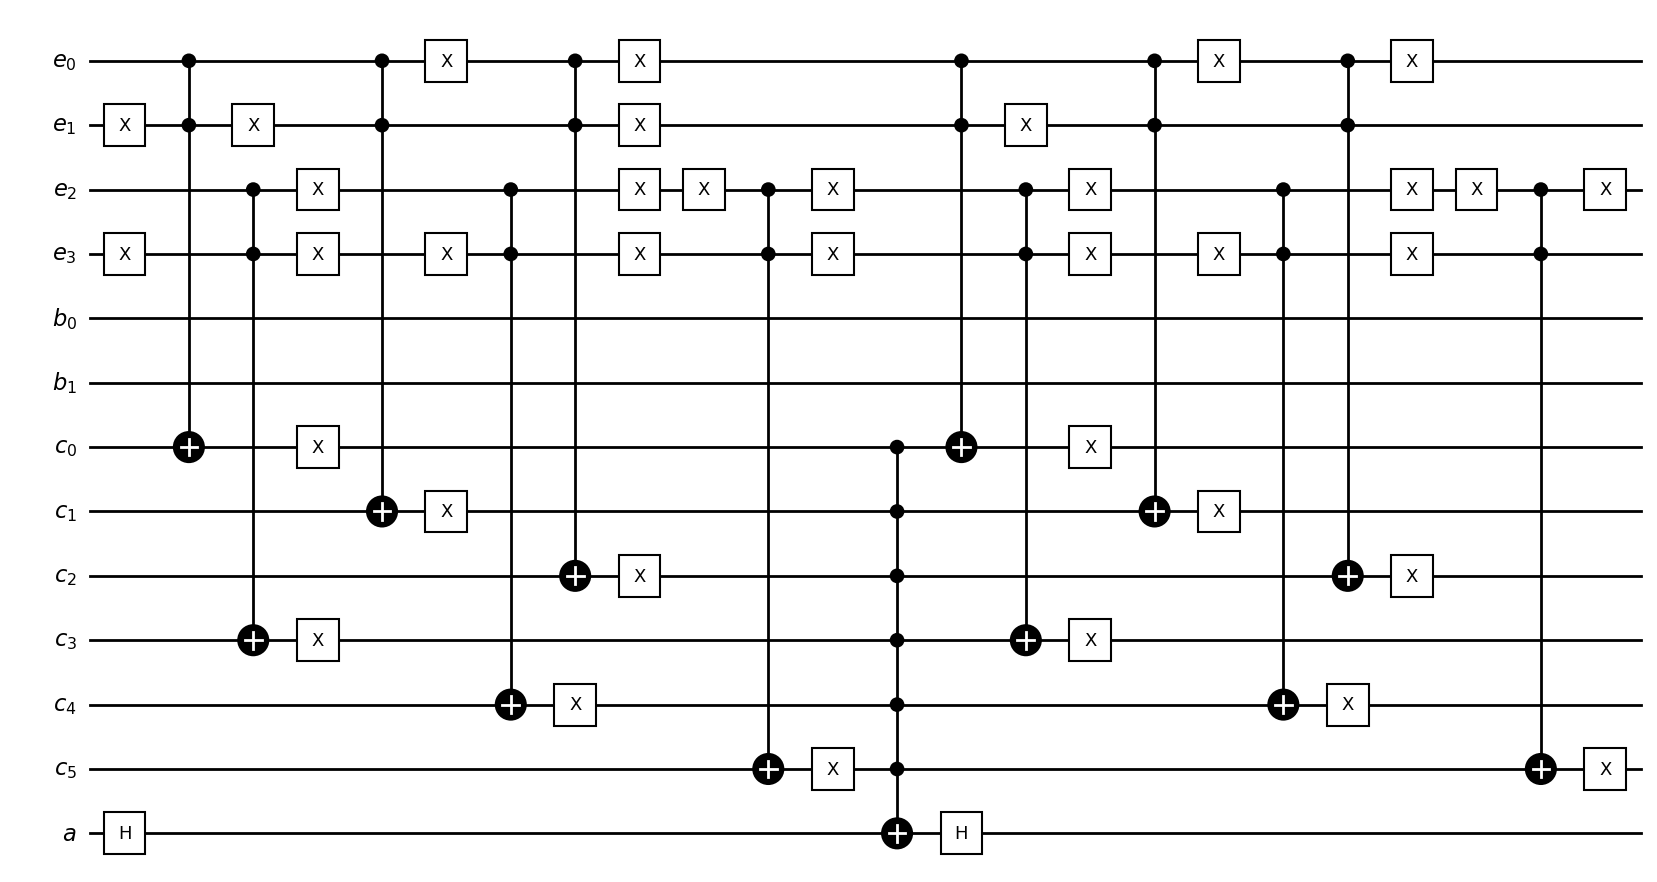

In [75]:
#Run to view circuit diagram
oracle_1(circuit_1, conditions)
circuit_1.draw(output="mpl", style="bw")

### Apply Grover's Algorithm

In [76]:
# Using:
# - sp : Number of empty cells
# - number_of_values : Number of options for a generic cell (Example: 4 in 4x4)
# - iterations : Optimal number of iterations
# - max_iterations : Maximum allowed number of iterations (may be kept blank)
# - circuit_1 : Grover's circuit (Oracle+Diffuser)

# Algorithm with t iterations
max_iterations = 101

# Calculate the total number of qubits
num_q = 2 * sp + 2 + len(conditions) + 1

def solving_sudoku(sp, num_q, number_of_values, max_iterations):

  cq = QuantumCircuit(num_q)

  #Allows a limit in the number of iterations smaller than the optimal.
  if max_iterations is not None and max_iterations < iterations:
      t = max_iterations
      print(f"Using {t} iterations (reduced from optimal number of iterations {iterations})")
  else:
      t = iterations

  #Create oracle and diffuser gates

  # The oracle_2 function modifies the circuit in place, so we need to apply it to a temporary circuit to get the gate
  # Create a temporary circuit for building the oracle gate
  # This temporary circuit should only contain the operations that make up the oracle
  # Recreate the QuantumRegister and AncillaRegister objects with the correct sizes and names
  # so that oracle_2 can be called correctly on temp_oracle_circuit
  blanks_temp = QuantumRegister(size = 2 * sp, name = 'e')
  bit_cal_temp = AncillaRegister(size = 2, name = 'b')
  cond_temp = AncillaRegister(size = len(cond), name = 'c')
  an_temp = AncillaRegister(size = 1, name = 'a')

  temp_oracle_circuit = QuantumCircuit()

  temp_oracle_circuit.add_register(blanks_temp)
  temp_oracle_circuit.add_register(bit_cal_temp)
  temp_oracle_circuit.add_register(cond_temp)
  temp_oracle_circuit.add_register(an_temp)


  # The oracle_2 function modifies the circuit in place, populate the temp circuit with oracle operations
  # Pass the temporary registers to the oracle_2 function
  oracle_1(temp_oracle_circuit, conditions)

  # Now, convert the temporary circuit (which only contains gate operations) to a gate
  oracle_gate = temp_oracle_circuit.to_gate(label="Oracle 1")

  # The diffuser function directly returns a gate
  diffuser_gate = diffuser(2 * sp)

  # Initialize the 'an' qubit in state |-> for the phase kickback
  cq.initialize([1, -1]/np.sqrt(2), num_q - 1)

  # Initialize the blank qubits to a uniform superposition
  cq.h(range(2 * sp))

  # Apply the iterations
  print(f"Running {t}-many Grover iterations")
  for i in range(t):
    if i % 10 == 0:
      print(f"Iteration {i}/{t}")

    cq.append(oracle_gate, range(num_q))
    cq.append(diffuser_gate, range(2 * sp))

  # Obtain the statevector
  statevector = Statevector(cq)

  # Get the probabilities
  prob = statevector.probabilities()

  # Find the index of the maximum probability
  most_probable_index = prob.argmax()

  # Convert the index to the corresponding binary string
  num_qubits = cq.num_qubits
  most_probable_state = format(most_probable_index, f'0{num_qubits}b')
  most_probable_state = most_probable_state[len(most_probable_state) - 2*sp:]

  print("Probabilities:", prob)
  print("Solution:", most_probable_state)
  print("Success probability:", prob[most_probable_index])
  return most_probable_state

#RUN

solution = solving_sudoku(sp, num_q, number_of_values, max_iterations)

Running 3-many Grover iterations
Iteration 0/3
Probabilities: [0.03125 0.03125 0.03125 ... 0.      0.      0.     ]
Solution: 1100
Success probability: 0.48065948486326143


In [77]:
#Decode solution and produce solved puzzle
def decode_solution(solution, location_b, A):
  final_solution = A
  for i in range(len(location_b)):
    bits1, bits2 = solution[2*i], solution[2*i + 1]
    bits1 = int(bits1)
    bits2 = int(bits2)
    value = 2*(bits1) + bits2
    location = location_b[len(location_b)-i-1]
    final_solution[location[0]][location[1]] = value
  return final_solution

decode_solution(solution, location_b, A)

array([['2', '0', '3', '1'],
       ['1', '3', '2', '0'],
       ['0', '2', '1', '3'],
       ['3', '1', '0', '2']], dtype='<U21')

In [78]:
#Reset A
A = np.array([2, 0, 3, 1, 1, 3, 2, '*', 0, 2, 1, 3, '*', 1, 0, 2])
A = A.reshape(4, 4)

## Oracle 2
Oracle 2 only checks rows and columns (since checking blocks creates too many registers and so it cannot be tested with given RAM).  It uses a circuit with one quantum register of size 2*(number of empty sodoku cells), one ancillia register of size 4 for single gate operations, one ancillia register of size 8 which marks 1 if that row/column condition is satisfied and 0 if not, and one ancillia register of size one which switches sign of |1> if all conditions are satisfied.

The following functions are used to build the algorithm:

### get_perm
Purpose: Find the possible permutations for the blank cells in each row and column

Parameters: A is a 4x4 matrix representing the sudoku puzzle, where blank squares are represented by '*'

Output: A list which contains a list of lists of possible permutations for each of the blank spaces in each of the rows and columns of the puzzle.

Method: Checks in each row and column which values are already filled, then produces the possible permutations from the leftover values

###translate_perm
Purpose: Turn the string values from a given permutation into binary values to be used for comparison in the oracle

Parameters: permutations is the list of possible permutations, cond_num is the number of the condition we want to check (0, 1, 2, 3 corresponds to the rows, in order, 4, 5, 6, 7 corresponds to the columns, in order)

Output: A list of the permutions for cond_num which is encoded in binary array

Method: Uses a dictionary to map 'number' to [first bit, second bit]

###return_col_indices

Purpose: Helper function that given a column number finds the blank spaces in that column

Parameters: location_b is the list of all empty spaces, i is the column number to examine

Output: Returns a list of positions in the given column where there is a blank space

Method: Standard search of location_b for which the second index is equal to the column value

###perm_1
Purpose: Check if a row or column with only one blank has the correct value in that cell

Parameters: circuit is the circuit we wish to alter, element_1_index is 2*(index number of a blank cell from location_b), permutations is the list of possible permutations for the specific row/column, cond_num is the row/col for which we are checking permutations (cond_num must originally hold 0)

Output: No output, but modifies the circuit to hold 1 in rcb[cond_num] if the given cell holds the correct value and 0 if not

Method: If the number in binary has a 0 in either bit, applies an x gate to the qubit representing that index's bit, then applies a Toffoli gate for which the controls are both bits representing the cell and the target is rcb[cond_num] so that rcb[cond_num] is 1 only if the number represented by two qubits in the position of the element index is the number in the permutation. Then returns everything except rcd[cond_num] to original state by applying operations a second time.

###perm_2
Purpose: Check if a row or column with two blanks has a valid permutation

Parameters: circuit is the circuit we wish to alter, element_1_index is 2x(first index number of a blank cell from location_b), element_2_index is 2x(second index number of a blank cell from location_b), permutations is the list of possible permutations for the specific row/column, cond_num is the row/col for which we are checking permutations (cond_num must originally hold 0)

Output: No output, but modifies the circuit to hold 1 in rcb[cond_num] if the given cells hold a correct permutation and 0 if not

Method: For each permutation, if the numbers in binary have a 0 in either bit, applies an x gate to the qubit representing that index's bit, then applies a Toffoli gate for which the controls are both bits representing the first cell and the target is bit_cal[0] (so bit_cal[0] is 1 only if the first cell contains the correct value for the permutation), and then applies a Toffoli gate for which the controls are both bits representing the second cell and the target is bit_cal[1] (so bit_cal[1] is 1 only if the first cell contains the correct value for the permutation).  Then applies a Toffoli gate for which the controls are bit_cal[0] and bit_cal[1] and the target is rcb[cond_num] so that rcb[cond_num] is 1 only if the permutation is valid.  Since the blanks can only contain at most one possible valid permutation, running through all the permutations will only flip rcb[cond_num] at most once for a valid permutation.  All operations are then applied again so that all registers are reset to their original values, except for rcb[cond_num].

###perm_3
Purpose: Check if a row or column with three blanks has a valid permutation

Parameters: circuit is the circuit we wish to alter, element_1_index is 2x(first index number of a blank cell from location_b), element_2_index is 2x(second index number of a blank cell from location_b), element_3_index is 2x(second index number of a blank cell from location_b), permutations is the list of possible permutations for the specific row/column, cond_num is the row/col for which we are checking permutations (cond_num must originally hold 0)

Output: No output, but modifies the circuit to hold 1 in rcb[cond_num] if the given cells hold a correct permutation and 0 if not

Method: For each permutation, if the numbers in binary have a 0 in either bit, applies an x gate to the qubit representing that index's bit, then applies a Toffoli gate for which the controls are both bits representing the first cell and the target is bit_cal[0] (so bit_cal[0] is 1 only if the first cell contains the correct value for the permutation), and then applies a Toffoli gate for which the controls are both bits representing the second cell and the target is bit_cal[1] (so bit_cal[1] is 1 only if the first cell contains the correct value for the permutation), and then applies a Toffoli gate for which the controls are both bits representing the third cell and the target is bit_cal[2] (so bit_cal[2] is 1 only if the first cell contains the correct value for the permutation).  Then a Toffoli gate for which the controls are bit_cal[0] and bit_cal[1] and the target is bit_cal[3] is applied so that bit_cal[3] is 1 only if the first and second cells have valid numbers for the permutation.  Then applies a Toffoli gate for which the controls are bit_cal[2] and bit_cal[3] and the target is rcb[cond_num] so that rcb[cond_num] is 1 only if the permutation is valid for all three cells.  Since the blanks can only contain at most one possible valid permutation, running through all the permutations will only flip rcb[cond_num] at most once for a valid permutation. All operations are then applied again so that all registers are reset to their original values, except for rcb[cond_num].

###oracle_2
*oracle_2 only works for a 4x4 puzzle*

Purpose: Check that all conditions for rows and columns are satisfied, and if they are, mark that state.

Parameters: circuit is the circuit we wish to alter, permutations is the list of all permutions for each row/col, location_b is the list of all of the locations for the blanks in the puzzle

Output: No output, but alters the given circuit to mark the state which satisfies all of the conditions

Method: Iterates through each row and column and checks if the possible permutations are satisfied for each.  Depending on the size of the permutation for each row/col, the functions perm_1, perm_2, or perm_3 are called to check conditions.  Then a multicontrolled z-gate is applied to the conditions, flipping the state of an only if all conditions are satisfied.

###solving_sudoku

Purpose: Find a solution for a 4×4 Puzzle by applying t Grover iterations (as given by iterations) and performing measurements. It also includes the option to impose a maximum number of iterations if the problem would otherwise require too many.

Parameters: The  parameter sp is the number of empty cells, num_q is the number of qubits involved in the Grover's code, number_of_values is the number of values that the cell can take in this case 4, max_iterations is one integer representing a maximum number of iterations to be computed.

Output: Solution, contains a solution for the problem writen as a list of 2 digit binary numbers. It also outputs the Success probability the empirical probability of obtaining such a solution.

Method: It creates the gates for the oracle and diffuser .Initialize the “an” qubit in |–⟩ for phase kickback and the blank qubits in uniform superposition.
Apply t alternating oracle and diffuser operations (t = min(iterations, max_iterations)). Measure the blank qubits.
Repeat steps this steps for 1024 shots (as it is the convention). Select as the solution the bitstring observed most frequently and report its relative frequency and empirical probability.

###decode_solution

Purpose: Take the given solution and fill in the blank cells of the sudoku with the solution

Parameters: solution is a binary string with the solutions (this string gives the solution in backwards order), location_b is the locations of the empty cells in the puzzle, A is the original puzzle

Output: final_solution is a completly filled sudoku puzzle with the blank values replaced with the correct numerical values

Method: Extracts the values from the string and uses their binary representation to fill the correct value.  Then puts the values into their correct cell of the given puzzle



### Extract the needed data from the puzzle

In [79]:
A

array([['2', '0', '3', '1'],
       ['1', '3', '2', '*'],
       ['0', '2', '1', '3'],
       ['*', '1', '0', '2']], dtype='<U21')

In [80]:
#Data for oracle 2
def get_perm(A):
  permutation = []

  #Find the different row permutations
  possible_val = ['0', '1', '2', '3']
  for i in range(len(A)):
    count = 0
    for j in range(len(A)):
      if [i, j] in location_b:
        count = count + 1
    if count == 0:
      permutation.append([])
    else:
      temp = []
      for val in possible_val:
        if val not in A[i]:
          temp.append(val)
      permutation.append(np.array(list(permutations(temp))))

  #Find the different column permutations
  for j in range(len(A)):
    count = 0
    for i in range(len(A)):
      if A[i][j] == '*':
        count = count + 1
    if count == 0:
      permutation.append([])
    else:
      temp = []
      for val in possible_val:
        if val not in A[:, j]:
          temp.append(val)
      permutation.append(np.array(list(permutations(temp))))
  return permutation

In [81]:
#View list of permutations
permutation = get_perm(A)
permutation

[[],
 array([['0']], dtype='<U1'),
 [],
 array([['3']], dtype='<U1'),
 array([['3']], dtype='<U1'),
 [],
 [],
 array([['0']], dtype='<U1')]

In [82]:
#Create dictionary to translate permutation data into useable data
dictionary = {
    '0' : [0, 0],
    '1' : [1, 0],
    '2' : [0, 1],
    '3' : [1, 1]
}

In [83]:
#Function translates permutation data at a condition into useable data for
#comparison
def translate_perm(permutations, cond_num):
  new_list = []
  if len(permutations[cond_num]) == 0:
    return new_list
  for perm in permutations[cond_num]:
    temp = []
    for i in range(len(perm)):
      temp.append(dictionary[perm[i]])
    new_list.append(temp)
  return new_list

In [84]:
def return_col_indices(location_b, i):
  empty_in = []
  for j in range(n**2):
    if [j, i] in location_b:
      empty_in.append(location_b.index([j, i]))
  return empty_in


### Build the oracle 2 circuit

In [85]:
#Build the circuit for oracle_2 to view circuit diagram

#Create a quantum register with 2*sp spaces
blanks = QuantumRegister(size = 2 * sp, name = 'e')

#Create ancilla register for computing if two bits are equal
bit_cal = AncillaRegister(size = 4, name = 'b')

#Create ancilla register for each of the conditions needed to be checked on
rcb = AncillaRegister(2*(n**2), name = 'r')

#Create ancillary which tests if all conditions have been met
an = AncillaRegister(size = 1, name = 'a')

#Create the circuit with all components
circuit_2 = QuantumCircuit(blanks, bit_cal, rcb, an)



### Build the oracle

In [86]:
#Function checks if circuit satisfies size one permutation at given index
def perm_1(circuit, element_1_index, permutations, cond_num):
  for perm in permutations:
    if perm[0][0] == 0:
      circuit.x(blanks[element_1_index])
    if perm[0][1] == 0:
      circuit.x(blanks[element_1_index + 1])

    circuit.ccx(blanks[element_1_index], blanks[element_1_index + 1], rcb[cond_num])

    #Return to original state
    if perm[0][0] == 0:
      circuit.x(blanks[element_1_index])
    if perm[0][1] == 0:
      circuit.x(blanks[element_1_index + 1])

In [87]:
def perm_2(circuit, element_1_index, element_2_index, permutations, cond_num):
  for perm in permutations:
    if perm[0][0] == 0:
      circuit.x(blanks[element_1_index])
    if perm[0][1] == 0:
      circuit.x(blanks[element_1_index + 1])
    circuit.ccx(blanks[element_1_index], blanks[element_1_index + 1], bit_cal[0])

    #Return to original state
    if perm[0][0] == 0:
      circuit.x(blanks[element_1_index])
    if perm[0][1] == 0:
      circuit.x(blanks[element_1_index + 1])

    #Check second set of values
    if perm[1][0] == 0:
      circuit.x(blanks[element_2_index])
    if perm[1][1] == 0:
      circuit.x(blanks[element_2_index + 1])
    circuit.ccx(blanks[element_2_index], blanks[element_2_index + 1], bit_cal[1])

    #Return to original state
    if perm[1][0] == 0:
      circuit.x(blanks[element_2_index])
    if perm[1][1] == 0:
      circuit.x(blanks[element_2_index + 1])

    #Mark rcb as 1 if conditions met, 0 else
    circuit.ccx(bit_cal[0], bit_cal[1], rcb[cond_num])



In [88]:
def perm_3(circuit, element_1_index, element_2_index, element_3_index, permutations, cond_num):
  for perm in permutations:
    if perm[0][0] == 0:
      circuit.x(blanks[element_1_index])
    if perm[0][1] == 0:
      circuit.x(blanks[element_1_index + 1])
    circuit.ccx(blanks[element_1_index], blanks[element_1_index + 1], bit_cal[0])

    #Return to original state
    if perm[0][0] == 0:
      circuit.x(blanks[element_1_index])
    if perm[0][1] == 0:
      circuit.x(blanks[element_1_index + 1])

    #Check second set of values
    if perm[1][0] == 0:
      circuit.x(blanks[element_2_index])
    if perm[1][1] == 0:
      circuit.x(blanks[element_2_index + 1])
    circuit.ccx(blanks[element_2_index], blanks[element_2_index + 1], bit_cal[1])

    #Return to original state
    if perm[1][0] == 0:
      circuit.x(blanks[element_2_index])
    if perm[1][1] == 0:
      circuit.x(blanks[element_2_index + 1])

    #Check third set of values
    if perm[2][0] == 0:
      circuit.x(blanks[element_3_index])
    if perm[2][1] == 0:
      circuit.x(blanks[element_3_index + 1])
    circuit.ccx(blanks[element_3_index], blanks[element_3_index + 1], bit_cal[2])

    #Return to original state
    if perm[2][0] == 0:
      circuit.x(blanks[element_3_index])
    if perm[2][1] == 0:
      circuit.x(blanks[element_3_index + 1])

    #Mark rcb as 1 if conditions met, 0 else
    circuit.ccx(bit_cal[0], bit_cal[1], bit_cal[3])
    circuit.ccx(bit_cal[2], bit_cal[3], rcb[cond_num])

In [89]:
def oracle_2(circuit, permutation, location_b):
  blank_num = 0
  #Test row conditions
  for i in range(n**2):
    if len(permutation[i]) == 0:
      circuit.x(rcb[i])
    elif len(permutation[i]) == 1:
      perm_1(circuit, blank_num, translate_perm(permutation, i), i)
      blank_num = blank_num + 2
    elif len(permutation[i]) == 2:
      perm_2(circuit, blank_num, blank_num + 2, translate_perm(permutation, i), i)
      blank_num = blank_num + 4
    elif len(permutation[i]) == 6:
      perm_3(circuit, blank_num, blank_num + 2, blank_num + 4, translate_perm(permutation, i), i)
      blank_num = blank_num + 6
  #Test column conditions
  for i in range(n**2):
    if len(permutation[i + n**2]) == 0:
      circuit.x(rcb[i + n**2])
    elif len(permutation[i + n**2]) == 1:
      li = return_col_indices(location_b, i)
      perm_1(circuit, 2*li[0], translate_perm(permutation, i + n**2), i + n**2)
    elif len(permutation[i + n**2]) == 2:
      li = return_col_indices(location_b, i)
      perm_2(circuit, 2*li[0], 2*li[1], translate_perm(permutation, i + n**2), i + n**2)
    elif len(permutation[i + n**2]) == 6:
      li = return_col_indices(location_b, i)
      perm_3(circuit, 2*li[0], 2*li[1], 2*li[2], translate_perm(permutation, i + n**2), i + n**2)

  #Check if all conditions are met by applying multicontrolled z gate, built from H(mcx)H since Z = HXH
  circuit.h(an)
  circuit.mcx(rcb, an)
  circuit.h(an)

  #redo all operations to reset registers
  blank_num = 0
  #Test row conditions
  for i in range(n**2):
    if len(permutation[i]) == 0:
      circuit.x(rcb[i])
    elif len(permutation[i]) == 1:
      perm_1(circuit, blank_num, translate_perm(permutation, i), i)
      blank_num = blank_num + 2
    elif len(permutation[i]) == 2:
      perm_2(circuit, blank_num, blank_num + 2, translate_perm(permutation, i), i)
      blank_num = blank_num + 4
    elif len(permutation[i]) == 6:
      perm_3(circuit, blank_num, blank_num + 2, blank_num + 4, translate_perm(permutation, i), i)
      blank_num = blank_num + 6
  #Test column conditions
  for i in range(n**2):
    if len(permutation[i + n**2]) == 0:
      circuit.x(rcb[i + n**2])
    elif len(permutation[i + n**2]) == 1:
      li = return_col_indices(location_b, i)
      perm_1(circuit, 2*li[0], translate_perm(permutation, i + n**2), i + n**2)
    elif len(permutation[i + n**2]) == 2:
      li = return_col_indices(location_b, i)
      perm_2(circuit, 2*li[0], 2*li[1], translate_perm(permutation, i + n**2), i + n**2)
    elif len(permutation[i + n**2]) == 6:
      li = return_col_indices(location_b, i)
      perm_3(circuit, 2*li[0], 2*li[1], 2*li[2], translate_perm(permutation, i + n**2), i + n**2)

  O = circuit.to_gate()
  return O


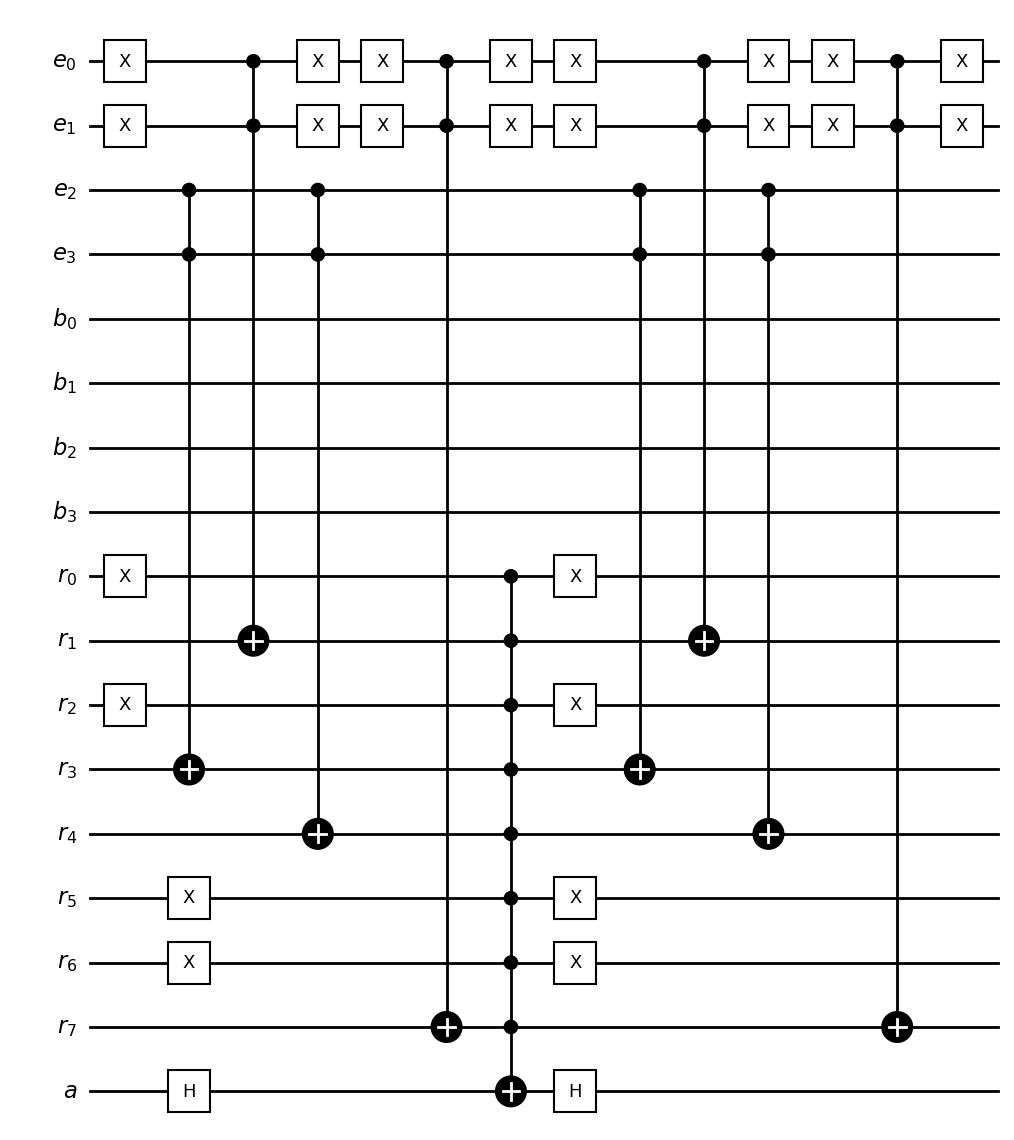

In [90]:
#Print diagram of the circuit
oracle_2(circuit_2, permutation, location_b)
circuit_2.draw(output="mpl", style="bw")

### Applying Grover's Algorithm with optimal number of iterations

In [91]:
# Using:
# - sp : Number of empty cells
# - number_of_values : Number of options for a generic cell (Example: 4 in 4x4)
# - iterations : Optimal number of iterations
# - max_iterations : Maximum allowed number of iterations (may be kept blank)
# - circuit_1 : Grover's circuit (Oracle+Diffuser)

# Algorithm with t iterations
max_iterations = 101

# Calculate the total number of qubits
num_q = 2 * sp + 2 + len(conditions) + 1

def solving_sudoku(sp, num_q, number_of_values, max_iterations):

  cq = QuantumCircuit(num_q)

  #Allows a limit in the number of iterations smaller than the optimal.
  if max_iterations is not None and max_iterations < iterations:
      t = max_iterations
      print(f"Using {t} iterations (reduced from optimal number of iterations {iterations})")
  else:
      t = iterations

  #Create oracle and diffuser gates

  # The oracle_2 function modifies the circuit in place, so we need to apply it to a temporary circuit to get the gate
  # Create a temporary circuit for building the oracle gate
  # This temporary circuit should only contain the operations that make up the oracle
  # Recreate the QuantumRegister and AncillaRegister objects with the correct sizes and names
  # so that oracle_2 can be called correctly on temp_oracle_circuit
  blanks_temp = QuantumRegister(size = 2 * sp, name = 'e')
  bit_cal_temp = AncillaRegister(size = 2, name = 'b')
  cond_temp = AncillaRegister(size = len(cond), name = 'c')
  an_temp = AncillaRegister(size = 1, name = 'a')

  temp_oracle_circuit = QuantumCircuit()

  temp_oracle_circuit.add_register(blanks_temp)
  temp_oracle_circuit.add_register(bit_cal_temp)
  temp_oracle_circuit.add_register(cond_temp)
  temp_oracle_circuit.add_register(an_temp)


  # The oracle_2 function modifies the circuit in place, populate the temp circuit with oracle operations
  # Pass the temporary registers to the oracle_2 function
  oracle_1(temp_oracle_circuit, conditions)

  # Now, convert the temporary circuit (which only contains gate operations) to a gate
  oracle_gate = temp_oracle_circuit.to_gate(label="Oracle 1")

  # The diffuser function directly returns a gate
  diffuser_gate = diffuser(2 * sp)

  # Initialize the 'an' qubit in state |-> for the phase kickback
  cq.initialize([1, -1]/np.sqrt(2), num_q - 1)

  # Initialize the blank qubits to a uniform superposition
  cq.h(range(2 * sp))

  # Apply the iterations
  print(f"Running {t}-many Grover iterations")
  for i in range(t):
    if i % 10 == 0:
      print(f"Iteration {i}/{t}")

    cq.append(oracle_gate, range(num_q))
    cq.append(diffuser_gate, range(2 * sp))

  # Obtain the statevector
  statevector = Statevector(cq)

  # Get the probabilities
  prob = statevector.probabilities()

  # Find the index of the maximum probability
  most_probable_index = prob.argmax()

  # Convert the index to the corresponding binary string
  num_qubits = cq.num_qubits
  most_probable_state = format(most_probable_index, f'0{num_qubits}b')
  most_probable_state = most_probable_state[len(most_probable_state) - 2*sp:]

  print("Probabilities:", prob)
  print("Solution:", most_probable_state)
  print("Success probability:", prob[most_probable_index])
  return most_probable_state

#RUN

solution = solving_sudoku(sp, num_q, number_of_values, max_iterations)

Running 3-many Grover iterations
Iteration 0/3
Probabilities: [0.03125 0.03125 0.03125 ... 0.      0.      0.     ]
Solution: 1100
Success probability: 0.48065948486326143


In [92]:
#Decode solution and produce solved puzzle
def decode_solution(binary_string, location_b, A):
  final_solution = A
  for i in range(len(location_b)):
    bits1, bits2 = binary_string[2*i], binary_string[2*i + 1]
    bits1 = int(bits1)
    bits2 = int(bits2)
    value = 2*(bits1) + bits2
    location = location_b[len(location_b)-i-1]
    final_solution[location[0]][location[1]] = value
  return final_solution

decode_solution(solution, location_b, A)

array([['2', '0', '3', '1'],
       ['1', '3', '2', '0'],
       ['0', '2', '1', '3'],
       ['3', '1', '0', '2']], dtype='<U21')